In [23]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets.cifar10 import load_data
A = load_data()

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
(X_train, y_train_), (X_test, y_test_) = A
y_train = y_train_.reshape(y_train_.shape[0],)
y_test = y_test_.reshape(y_test_.shape[0],)
print ('X_train: ', X_train.shape)
print ('y_train: ', y_train.shape)
print ('X_test: ', X_test.shape)
print ('y_test: ', y_test.shape)

X_train:  (50000, 32, 32, 3)
y_train:  (50000,)
X_test:  (10000, 32, 32, 3)
y_test:  (10000,)


[    6    13    18 ... 49987 49991 49995]


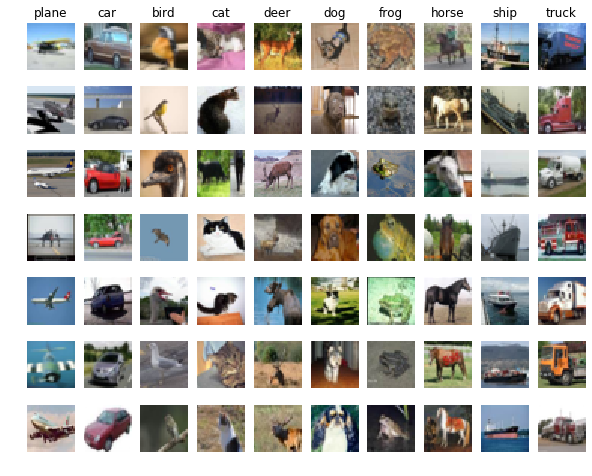

In [27]:
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7 # mỗi class gồm 7 hình ảnh
print(np.flatnonzero(y_train == 2))
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [28]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500
# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]
# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print ('Train data shape: ', X_train.shape)
print ('Train labels shape: ', y_train.shape)
print ('Validation data shape: ', X_val.shape)
print ('Validation labels shape: ', y_val.shape)
print ('Test data shape: ', X_test.shape)
print ('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [29]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print ('Training data shape: ', X_train.shape)
print ('Validation data shape: ', X_val.shape)
print ('Test data shape: ', X_test.shape)
print ('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[ 7.65366183e-14 -3.96153677e-14 -3.69018195e-15  8.09918373e-13
  2.57759963e-13 -2.13742856e-15 -7.91800258e-13  5.34096123e-15
 -1.06572710e-14  8.74573701e-14]


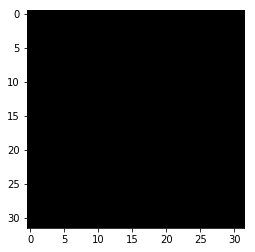

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


In [34]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print (mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()
# second: subtract the mean image from train and test data
X_train = X_train - mean_image
X_val   = X_val   - mean_image
X_test  = X_test  - mean_image
X_dev   = X_dev   - mean_image
# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print (X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

# SVM Classifier
Your code for this section will all be written inside Bai 14. MultiClass SVM.

As you can see, we have prefilled the function compute_loss_naive which uses for loops to evaluate the multiclass SVM loss function.

In [51]:
# naive way to calculate loss and grad
def svm_loss_naive(W,X,y,reg):
    d,C = W.shape # W(d,C)
    _,N = X.shape # X (N)
    # naive loss and grad
    loss =0 # loss = 1/N *sum(max(margin)) + reg/2* sum(w*w)
    dw = np.zeros_like(W) # đạo hàm : nếu margin<0 =>đạo hàm =0;còn nếu >0 => đạo hàm sẽ = -Xn nếu đạo hàm theo Wyn, còn đạo hàm sẽ bằng Xn nếu đạo hàm theo Wj
    for n in range(N):
        xn = X[:,n] # 1 điểm dữ liệu
        score = W.T.dot(xn) # zn
        for j in range(C):
            if( j == y[n]):
                continue
            margin = 1 - score[y[n]] + score[j] # margin = 1 - (Wyn).T* xn + (Wj).T*xn
            if margin >0:
                loss += margin
                dw[:,y[n]] -= xn
                dw[:,j]    += xn
    # loss function
    loss /=N
    loss += 0.5*reg*np.sum(W*W) # + regularization
    # grad
    dw /=N
    dw += reg*W
    return loss, dw

# Tính hàm mất mát và đạo hàm của nó bằng cách vectorized ( giảm hơn 140 lần đạo hàm bằng vòng for)
def svm_loss_vectorized(W,X,y,reg):
    d, C = W.shape
    _, N = X.shape
    loss =0
    dw = np.zeros_like(W)
    
    Z = W.T.dot(X)
    correct_class_score = np.choose(y,Z).reshape(N,1).T
    margin = np.maximum(0,Z - correct_class_score +1)
    margin[y, np.arange(margin.shape[1])] = 0
    loss = np.sum( margin, axis =(0,1))
    loss /=N
    loss += 0.5*reg*np.sum(W*W)
    
    F = (margin > 0).astype(int)
    F [y, np.arange(F.shape[1])] = np.sum(-F, axis =0)
    dw = X.dot(F.T)/N + reg*W
    return loss, dw
import time
# Next implement the function svm_loss_vectorized; for now only compute the loss;
# we will implement the gradient in a moment.
# generate a random SVM weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001 
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev.T, y_dev, 0.00001)
toc = time.time()
print ('Naive loss: %e computed in %fs' % (loss_naive, toc - tic))

tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_dev.T, y_dev, 0.00001)
toc = time.time()
print ('Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print ('difference: %f' % (loss_naive - loss_vectorized))

# Complete the implementation of svm_loss_vectorized, and compute the gradient
# of the loss function in a vectorized way.

# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev.T, y_dev, 0.00001)
toc = time.time()
print ('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev.T, y_dev, 0.00001)
toc = time.time()
print ('Vectorized loss and gradient: computed in %fs' % (toc - tic))

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print ('difference: %f' % difference)

Naive loss: 9.503516e+00 computed in 0.093728s
Vectorized loss: 9.503516e+00 computed in 0.000000s
difference: 0.000000
Naive loss and gradient: computed in 0.093729s
Vectorized loss and gradient: computed in 0.000000s
difference: 0.000000


# Stochastic Gradient Descent
We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss.

In [ ]:
# còn áp dụng LinearSVM  để create model train => predict
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
from cs231n.classifiers import LinearSVM
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=5e-7, reg=5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print 'That took %fs' % (toc - tic)

# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()
# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = svm.predict(X_train)
print 'training accuracy: %f' % (np.mean(y_train == y_train_pred), )
y_val_pred = svm.predict(X_val)
print 'validation accuracy: %f' % (np.mean(y_val == y_val_pred), )


# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.4 on the validation set.
learning_rates = [1e-7, 2e-7, 3e-7, 8e-7]
regularization_strengths = [1e4, 2e4, 3e4, 4e4, 5e4, 6e4, 7e4, 8e4, 1e5]

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.

################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a linear SVM on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the LinearSVM object that achieves this  #
# accuracy in best_svm.                                                        #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the SVMs don't take much time to train; once you are #
# confident that your validation code works, you should rerun the validation   #
# code with a larger value for num_iters.                                      #
################################################################################
# pass
for lr in learning_rates:
    for r in regularization_strengths:
        svm = LinearSVM()
        loss_hist = svm.train(X_train, y_train, learning_rate=lr, reg=r,
                      num_iters=2500, verbose=False)
        y_train_pred = svm.predict(X_train)
        
        y_val_pred = svm.predict(X_val)
        acc_train = np.mean(y_train == y_train_pred)
        acc_val = np.mean(y_val == y_val_pred)
        results[(lr, r)] = (acc_train, acc_val)
        print lr, r, acc_train, acc_val
        if acc_val > best_val:
            best_val = acc_val
            best_svm = svm
# print 'validation accuracy: %f' % (np.mean(y_val == y_val_pred), )
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print 'lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy)
    
print 'best validation accuracy achieved during cross-validation: %f' % best_val


# Visualize the cross-validation results
import math
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

# Evaluate the best svm on test set
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print 'linear SVM on raw pixels final test set accuracy: %f' % test_accuracy

# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best_svm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in xrange(10):
  plt.subplot(2, 5, i + 1)
    
  # Rescale the weights to be between 0 and 255
  wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
  plt.imshow(wimg.astype('uint8'))
  plt.axis('off')
  plt.title(classes[i])